<a href="https://colab.research.google.com/github/RomaTruba/PractikaScoring/blob/main/PractikaNS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, r2_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, ClassifierMixin

In [2]:
df = pd.read_csv('/content/bank.csv')

In [3]:
print(df.head())


   age          job  marital  education default  balance housing loan  \
0   30   unemployed  married    primary      no     1787      no   no   
1   33     services  married  secondary      no     4789     yes  yes   
2   35   management   single   tertiary      no     1350     yes   no   
3   30   management  married   tertiary      no     1476     yes  yes   
4   59  blue-collar  married  secondary      no        0     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome   y  
0  cellular   19   oct        79         1     -1         0  unknown  no  
1  cellular   11   may       220         1    339         4  failure  no  
2  cellular   16   apr       185         1    330         1  failure  no  
3   unknown    3   jun       199         4     -1         0  unknown  no  
4   unknown    5   may       226         1     -1         0  unknown  no  


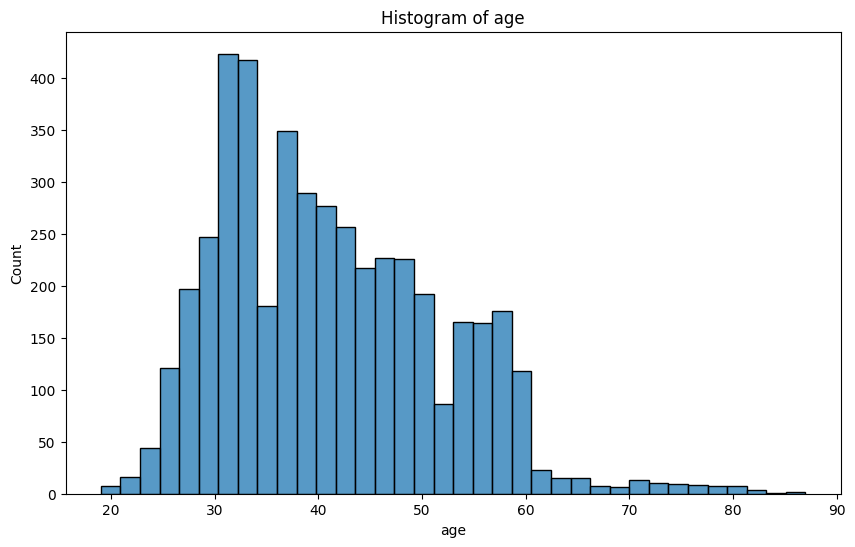

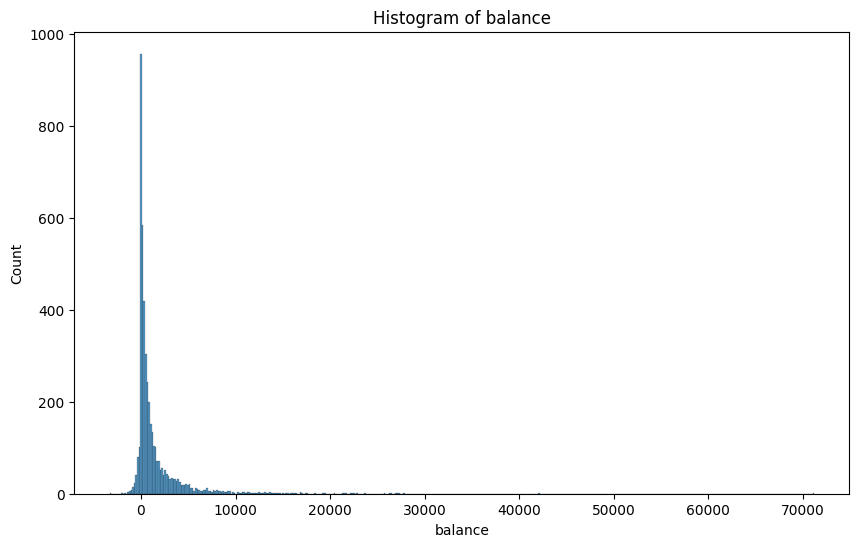

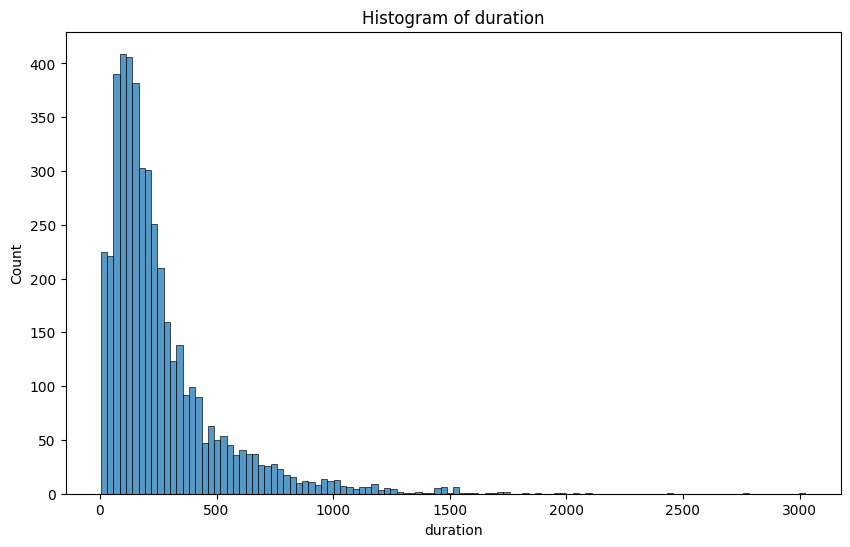

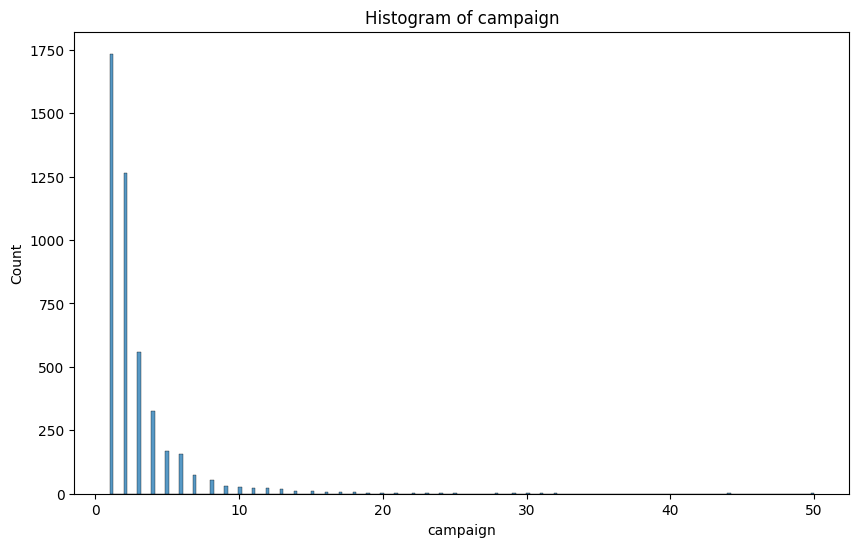

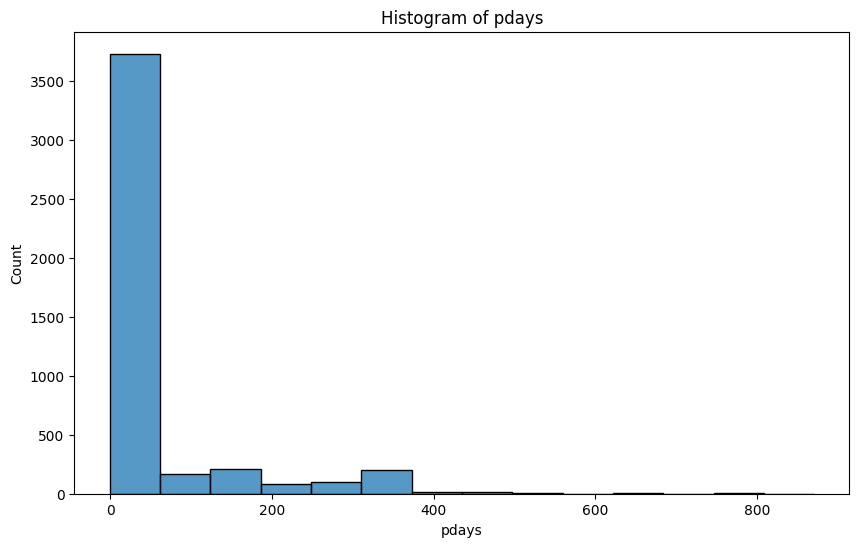

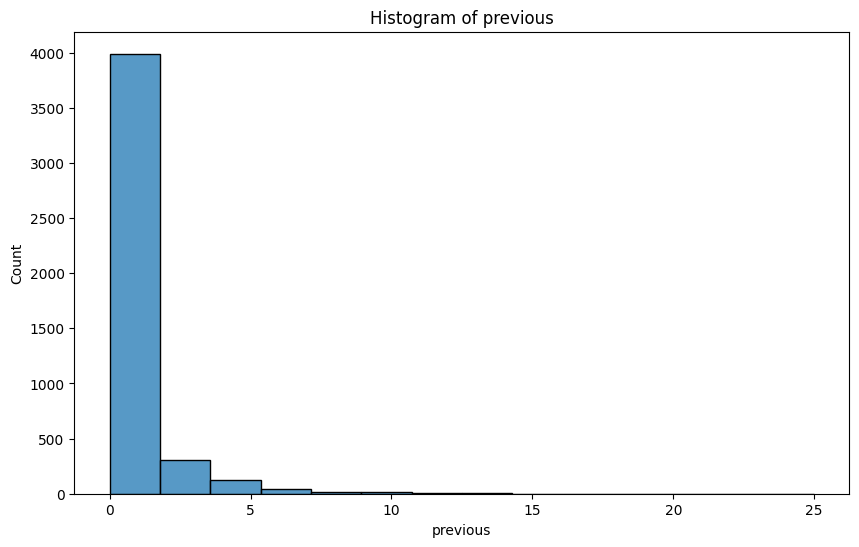

In [4]:
numerical_features = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

for feature in numerical_features:
    if feature in df.columns:
        plt.figure(figsize=(10, 6))
        sns.histplot(data=df, x=feature)
        plt.title(f'Histogram of {feature}')
        plt.show()

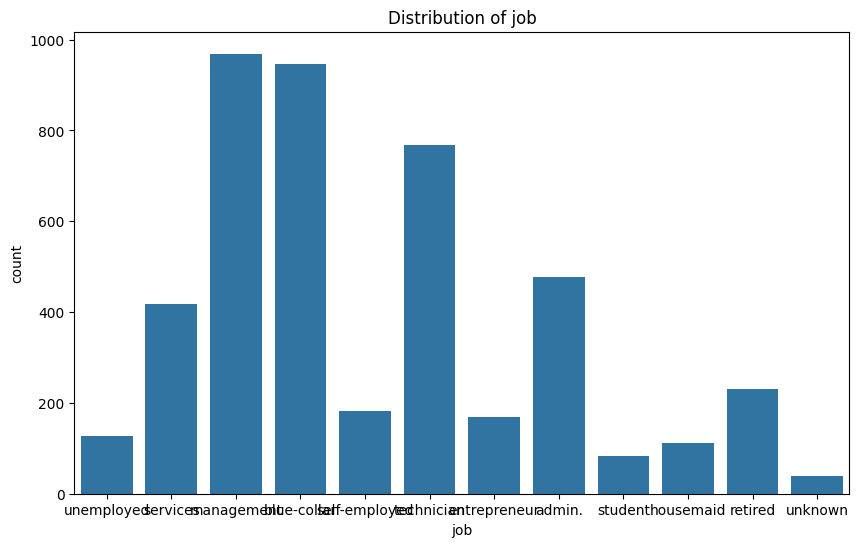

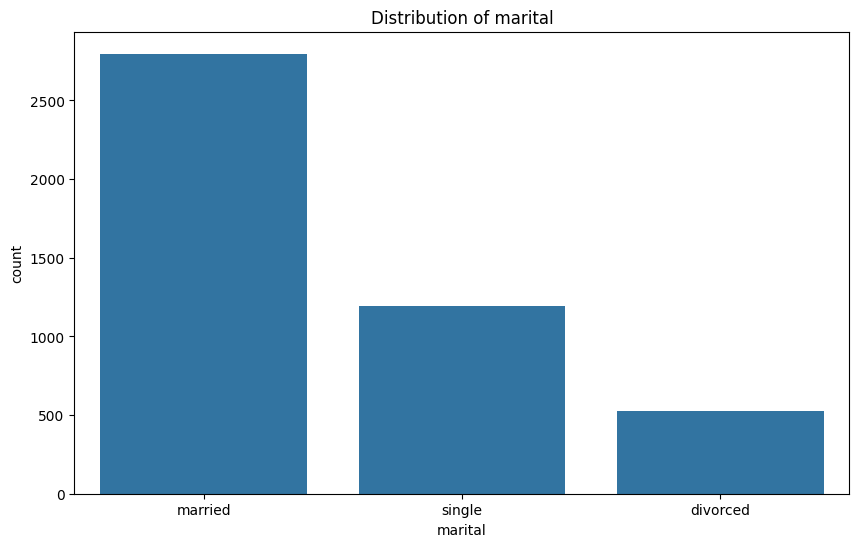

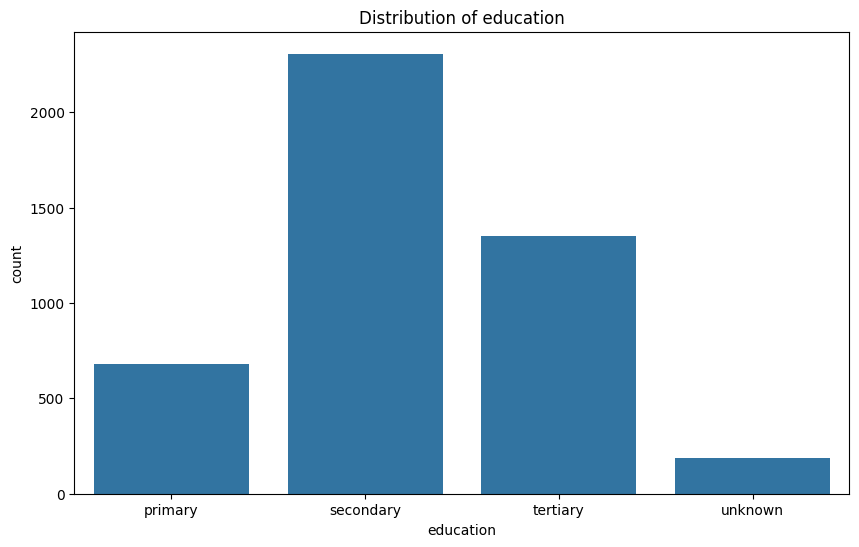

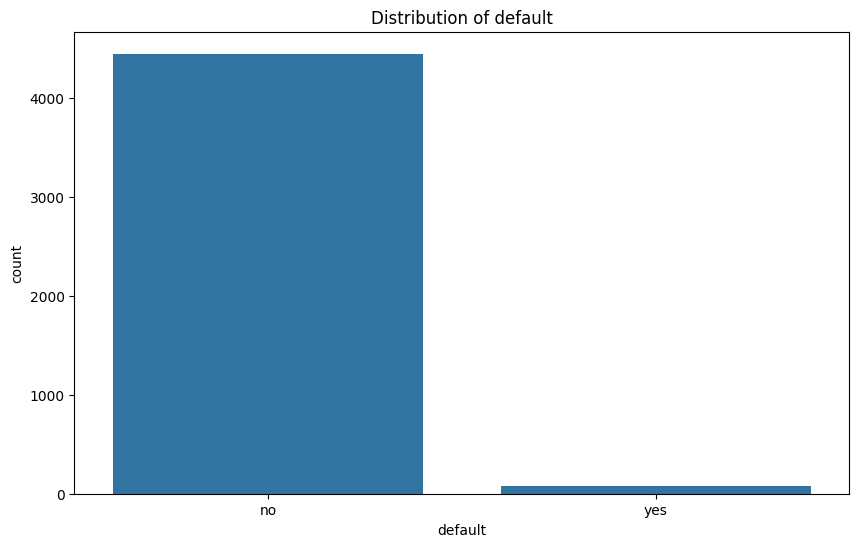

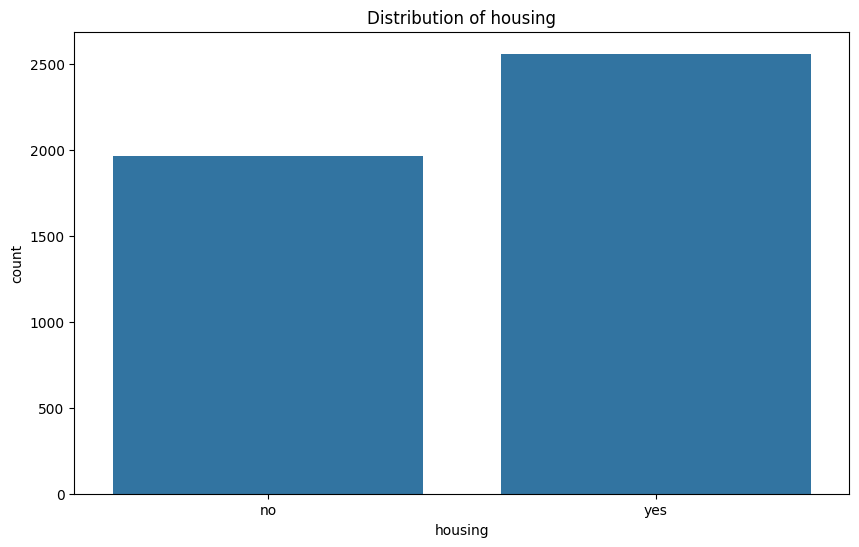

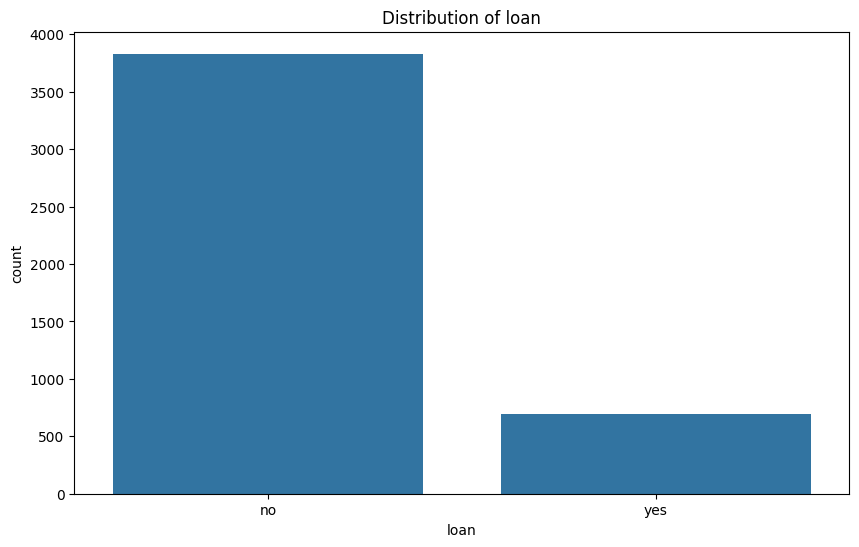

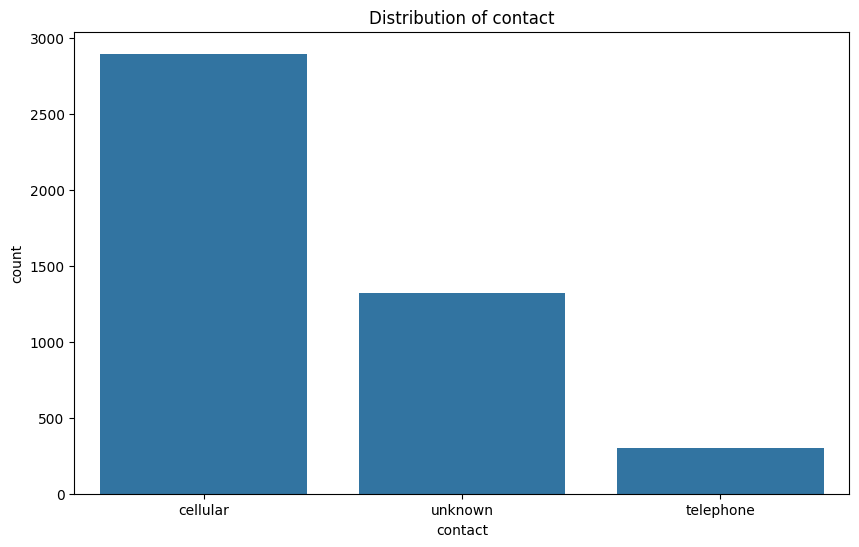

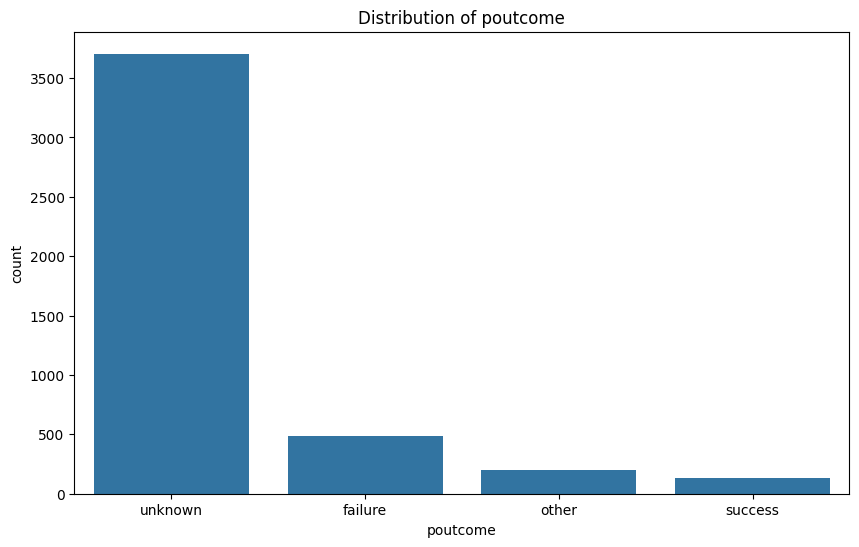

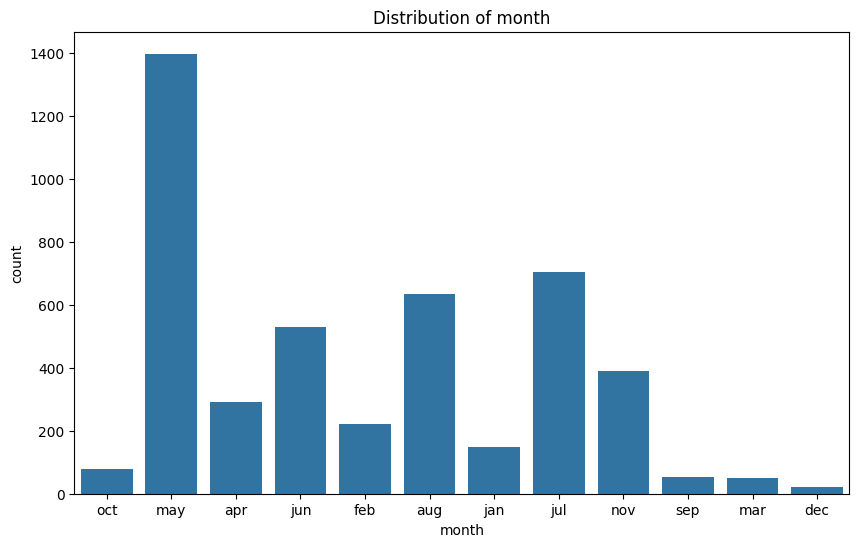

In [5]:
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome', 'month']

for feature in categorical_features:
    if feature in df.columns:
        plt.figure(figsize=(10, 6))
        sns.countplot(x=feature, data=df)
        plt.title(f'Distribution of {feature}')
        plt.show()

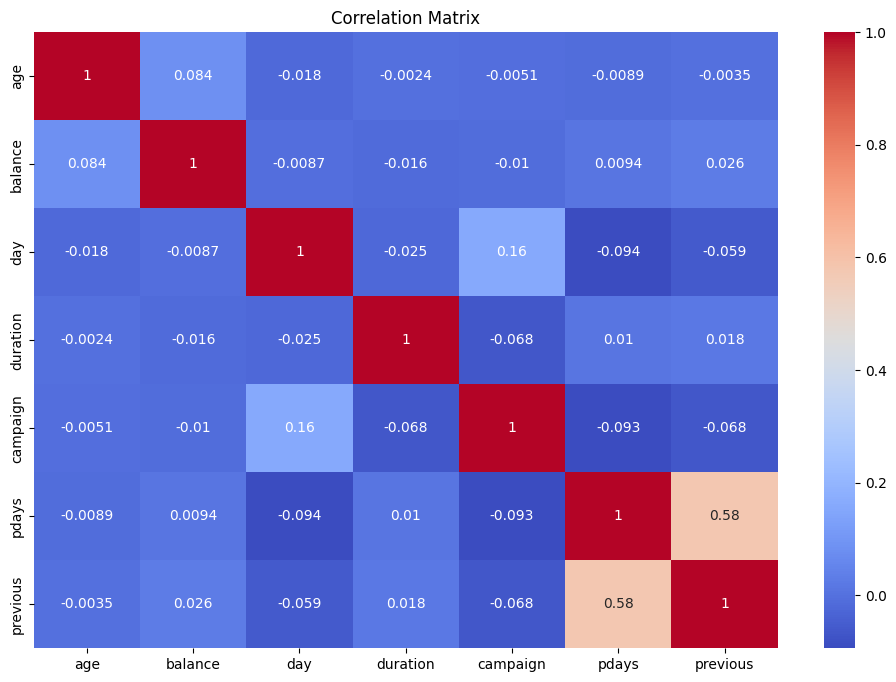

In [6]:
corr = df.corr(numeric_only = True)
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [7]:
X = df.drop(columns=['y'])
y = df['y']

In [8]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_encoded = encoder.fit_transform(X[categorical_features])
X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_features))
X = pd.concat([X.drop(columns=categorical_features), X_encoded_df], axis=1)

In [9]:
numerical_cols = X.select_dtypes(include=np.number).columns
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
le_target = LabelEncoder()
y_train = le_target.fit_transform(y_train)
y_test = le_target.transform(y_test)

In [12]:

class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        return self

    def predict(self, X):
         y_pred_prob = self.model.predict(X).flatten()
         return np.where(y_pred_prob > 0.5, 1, 0)

    def score(self, X, y):
        y_pred_prob = self.model.predict(X).flatten()
        y_pred = np.where(y_pred_prob > 0.5, 1, 0)
        return accuracy_score(y, y_pred)

In [13]:
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [15]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [16]:
history = model.fit(X_train, y_train,
                    epochs=200,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8521 - loss: 0.4125 - val_accuracy: 0.8917 - val_loss: 0.2663
Epoch 2/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8802 - loss: 0.2813 - val_accuracy: 0.8972 - val_loss: 0.2484
Epoch 3/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9031 - loss: 0.2466 - val_accuracy: 0.8961 - val_loss: 0.2405
Epoch 4/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9054 - loss: 0.2334 - val_accuracy: 0.8928 - val_loss: 0.2351
Epoch 5/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9035 - loss: 0.2215 - val_accuracy: 0.8928 - val_loss: 0.2326
Epoch 6/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9099 - loss: 0.2198 - val_accuracy: 0.8895 - val_loss: 0.2320
Epoch 7/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9179 - loss: 0.1993 - val_accuracy: 0.8906 - val_loss: 0.2300
Epoch 8/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9180 - loss: 0.1951 - val_accu

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.94       807
           1       0.50      0.54      0.52        98

    accuracy                           0.89       905
   macro avg       0.72      0.74      0.73       905
weighted avg       0.90      0.89      0.89       905


ROC AUC score:
 0.8974660496168727
R2 Score: -0.1329


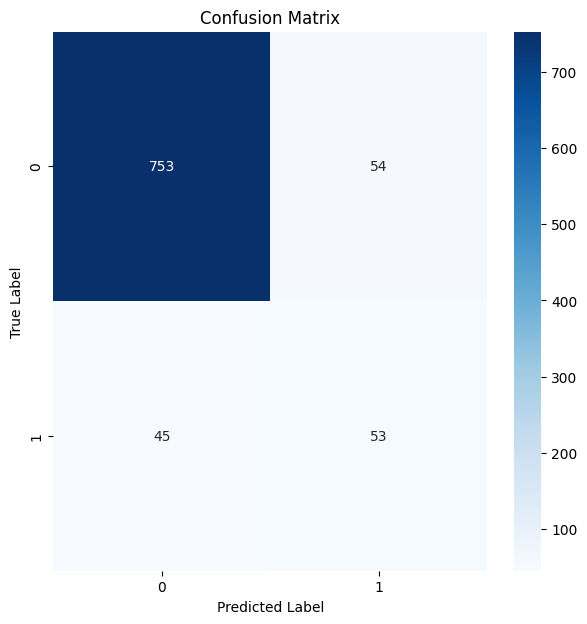

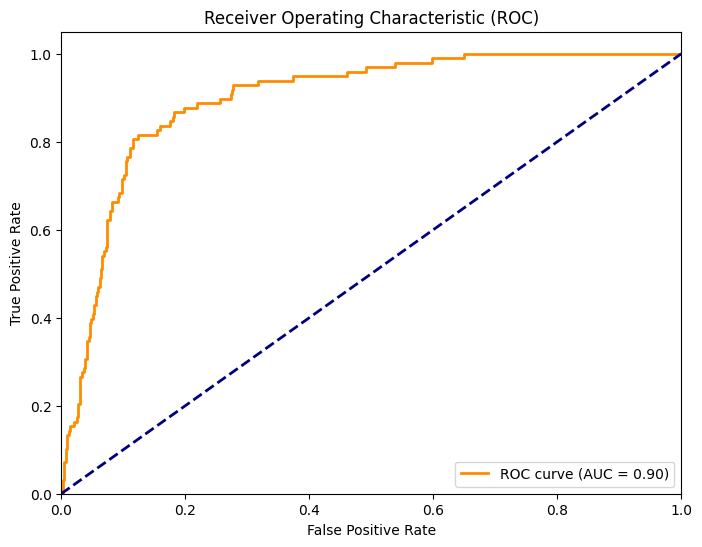

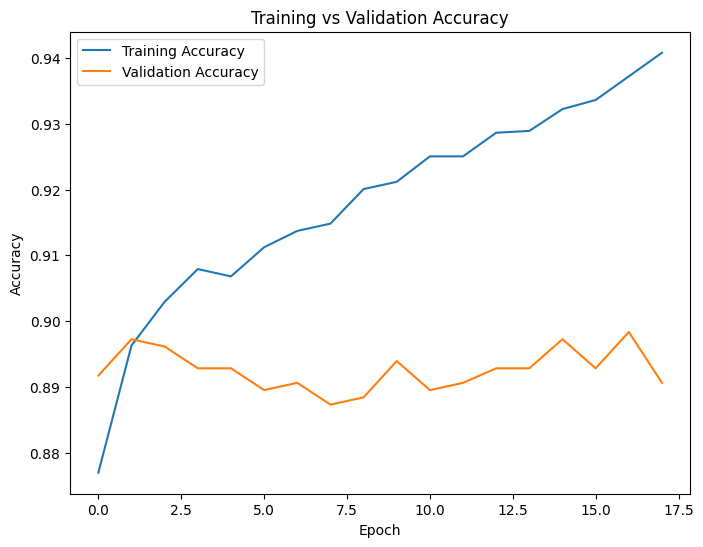

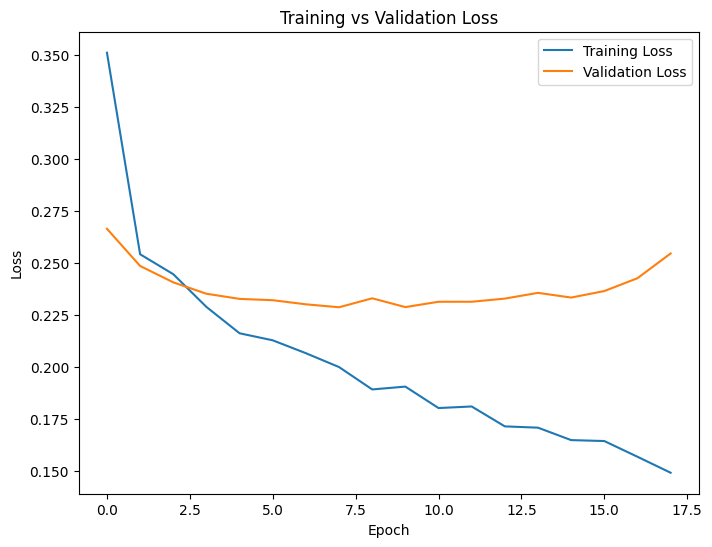

In [20]:
y_pred_prob = model.predict(X_test).flatten()
y_pred = np.where(y_pred_prob > 0.5, 1, 0)

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC AUC score:\n", roc_auc_score(y_test, y_pred_prob))
r2 = r2_score(y_test, y_pred)
print(f"R2 Score: {r2:.4f}")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
model_wrapper = KerasClassifierWrapper(model)
result = permutation_importance(model_wrapper, X_test, y_test, n_repeats=10, random_state=42)
importance = pd.Series(result.importances_mean, index=X_test.columns)
importance_sorted = importance.sort_values(ascending=False)

print("\nFeature Importance:\n", importance_sorted)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━

In [24]:
top_n = 5
print("\nTop",top_n,"Наиболее важных особенностей:\n", importance_sorted.head(top_n))


Top 5 Наиболее важных особенностей:
 duration           0.049834
month_jun          0.005635
month_nov          0.005304
day                0.005304
contact_unknown    0.005193
dtype: float64
